In [3]:
# Standard library
import random
import time
from argparse import ArgumentParser

# Third-party
import pytorch_lightning as pl
import torch
from lightning_fabric.utilities import seed

# First-party
from neural_lam import constants, utils
from neural_lam.models.graph_lam import GraphLAM
from neural_lam.models.hi_lam import HiLAM
from neural_lam.models.hi_lam_parallel import HiLAMParallel
from neural_lam.weather_dataset import WeatherDataset


import argparse

# Manually create the args Namespace object with the desired parameters
args = argparse.Namespace(
    dataset='meps_example',
    model='graph_lam',
    subset_ds=0,
    seed=42,
    n_workers=4,
    epochs=200,
    batch_size=1,
    load=None,
    restore_opt=0,
    precision=32,
    graph='1level',
    hidden_dim=32,
    hidden_layers=1,
    processor_layers=1,
    mesh_aggr='sum',
    output_std=0,
    ar_steps=1,
    control_only=0,
    loss='wmse',
    step_length=3,
    lr=0.001,
    val_interval=1,
    eval='test',
    n_example_pred=1
)

print('args', args)
print('args', args.dataset)
MODELS = {
    "graph_lam": GraphLAM,
    "hi_lam": HiLAM,
    "hi_lam_parallel": HiLAMParallel,
}


# Asserts for arguments
assert args.model in MODELS, f"Unknown model: {args.model}"
assert args.step_length <= 3, "Too high step length"
assert args.eval in (
    None,
    "val",
    "test",
), f"Unknown eval setting: {args.eval}"
print('args',args)
# Get an (actual) random run id as a unique identifier
random_run_id = random.randint(0, 9999)

# Set seed
seed.seed_everything(args.seed)

# Load data
train_loader = torch.utils.data.DataLoader(
    WeatherDataset(
        args.dataset,
        pred_length=args.ar_steps,
        split="train",
        subsample_step=args.step_length,
        subset=bool(args.subset_ds),
        control_only=args.control_only,
    ),
    args.batch_size,
    shuffle=True,
    num_workers=args.n_workers,
)
max_pred_length = (65 // args.step_length) - 2  # 19
val_loader = torch.utils.data.DataLoader(
    WeatherDataset(
        args.dataset,
        pred_length=max_pred_length,
        split="val",
        subsample_step=args.step_length,
        subset=bool(args.subset_ds),
        control_only=args.control_only,
    ),
    args.batch_size,
    shuffle=False,
    num_workers=args.n_workers,
)

# Instantiate model + trainer
if torch.cuda.is_available():
    device_name = "cuda"
    torch.set_float32_matmul_precision(
        "high"
    )  # Allows using Tensor Cores on A100s
else:
    device_name = "cpu"

# Load model parameters Use new args for model
model_class = MODELS[args.model]
# if args.load:
#     model = model_class.load_from_checkpoint(args.load, args=args)
#     if args.restore_opt:
#         # Save for later
#         # Unclear if this works for multi-GPU
#         model.opt_state = torch.load(args.load)["optimizer_states"][0]
# else:
#     model = model_class(args)

prefix = "subset-" if args.subset_ds else ""
if args.eval:
    prefix = prefix + f"eval-{args.eval}-"
run_name = (
    f"{prefix}{args.model}-{args.processor_layers}x{args.hidden_dim}-"
    f"{time.strftime('%m_%d_%H')}-{random_run_id:04d}"
)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"saved_models/{run_name}",
    filename="min_val_loss",
    monitor="val_mean_loss",
    mode="min",
    save_last=True,
)
logger = pl.loggers.WandbLogger(
    project=constants.WANDB_PROJECT, name=run_name, config=args
)
trainer = pl.Trainer(
    max_epochs=args.epochs,
    deterministic=True,
    strategy="ddp_notebook",
    accelerator=device_name,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback],
    check_val_every_n_epoch=args.val_interval,
    precision=args.precision,
)

# Only init once, on rank 0 only
if trainer.global_rank == 0:
    utils.init_wandb_metrics(logger)  # Do after wandb.init

if args.eval:
    if args.eval == "val":
        eval_loader = val_loader
    else:  # Test
        eval_loader = torch.utils.data.DataLoader(
            WeatherDataset(
                args.dataset,
                pred_length=max_pred_length,
                split="test",
                subsample_step=args.step_length,
                subset=bool(args.subset_ds),
            ),
            args.batch_size,
            shuffle=False,
            num_workers=args.n_workers,
        )

    print(f"Running evaluation on {args.eval}")
    # trainer.test(model=model, dataloaders=eval_loader)
else:
    # Train model
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)


Seed set to 42


args Namespace(dataset='meps_example', model='graph_lam', subset_ds=0, seed=42, n_workers=4, epochs=200, batch_size=1, load=None, restore_opt=0, precision=32, graph='1level', hidden_dim=32, hidden_layers=1, processor_layers=1, mesh_aggr='sum', output_std=0, ar_steps=1, control_only=0, loss='wmse', step_length=3, lr=0.001, val_interval=1, eval='test', n_example_pred=1)
args meps_example
args Namespace(dataset='meps_example', model='graph_lam', subset_ds=0, seed=42, n_workers=4, epochs=200, batch_size=1, load=None, restore_opt=0, precision=32, graph='1level', hidden_dim=32, hidden_layers=1, processor_layers=1, mesh_aggr='sum', output_std=0, ar_steps=1, control_only=0, loss='wmse', step_length=3, lr=0.001, val_interval=1, eval='test', n_example_pred=1)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id 5xf6kbi1.


Running evaluation on test
Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


In [5]:
# Example usage:
# Initialize your model and dataloader
# model = YourModelClass(...)
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader
import sys
sys.path.append("/home/aw1223/ip/agile/")

from sdk.tracer import Tracer
tracer = Tracer()
model_graph = tracer.trace_pl(model, eval_loader)
tracer.plot_model(model_graph, "model_io_graph", format='png', dpi=300)

TypeError: Render.render() got an unexpected keyword argument 'dpi'

In [39]:
import torch
from graphviz import Digraph
from IPython.display import Image, display
from neural_lam.interaction_net import  InteractionNet

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order).
    """
    io_dict = {}
    tensor_id_to_name = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace
    # print('io_dict', io_dict)
    for key, value in io_dict.items():
        print('key', key)
        print('value', value)
    return io_dict

def get_node_color(module):
    """
    Returns the color for the node based on the module type.
    """
    if isinstance(module, torch.nn.Linear):
        return 'lightblue'
    elif isinstance(module, InteractionNet):
        return 'lightgreen'
    elif isinstance(module, torch.nn.Sequential):
        return 'orange'
    # Add other module types as needed
    return 'white'  # Default color

def plot_simplified_model_io_graph_with_order_and_track(model, io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations, and includes color-coding
    and annotations for the feature/channel count.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model.
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order) in io_dict.items():
        # Extract the top-level module name only
        top_level_module_name = module_name.split('.')[0]

        # Get the module and determine its color and shape
        module = dict(model.named_modules())[top_level_module_name]
        node_color = get_node_color(module)
        shape = 'box' if node_color != 'white' else 'ellipse'

        # Annotate the node with feature/channel count
        annotation = f"{top_level_module_name}\nFeatures: {module.out_features if hasattr(module, 'out_features') else 'N/A'}"
        
        # Create a node for the top-level module
        if top_level_module_name not in dot.node_attr:
            dot.node(top_level_module_name, annotation, shape=shape, style='filled', fillcolor=node_color)

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, top_level_module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(top_level_module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io = trace_lightning_model_io_with_order_and_track(model, eval_loader)



Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


key grid_embedder
value (['g2m_gnn_output_0'], ['grid_embedder_output_0'], [468, 469])
key g2m_embedder
value (['g2m_embedder_input_0'], ['g2m_embedder_output_0'], [470, 471])
key m2g_embedder
value (['m2g_embedder_input_0'], ['m2g_embedder_output_0'], [472, 473])
key mesh_embedder
value (['mesh_embedder_input_0'], ['mesh_embedder_output_0'], [474, 475])
key g2m_gnn
value (['grid_embedder_output_0', 'mesh_embedder_output_0', 'grid_embedder_output_0'], ['g2m_gnn_output_0'], [476, 477, 478, 479])
key encoding_grid_mlp
value (['grid_embedder_output_0'], ['encoding_grid_mlp_output_0'], [480, 481])
key m2m_embedder
value (['m2m_embedder_input_0'], ['m2m_embedder_output_0'], [482, 483])
key processor
value (['g2m_gnn_output_0', 'processor_input_1'], ['processor_output_0', 'processor_output_1'], [484, 485, 486, 487])
key m2g_gnn
value (['processor_output_0', 'g2m_gnn_output_0', 'processor_output_1'], ['m2g_gnn_output_0'], [488, 489, 490, 491])
key output_map
value (['m2g_gnn_output_0'], ['out

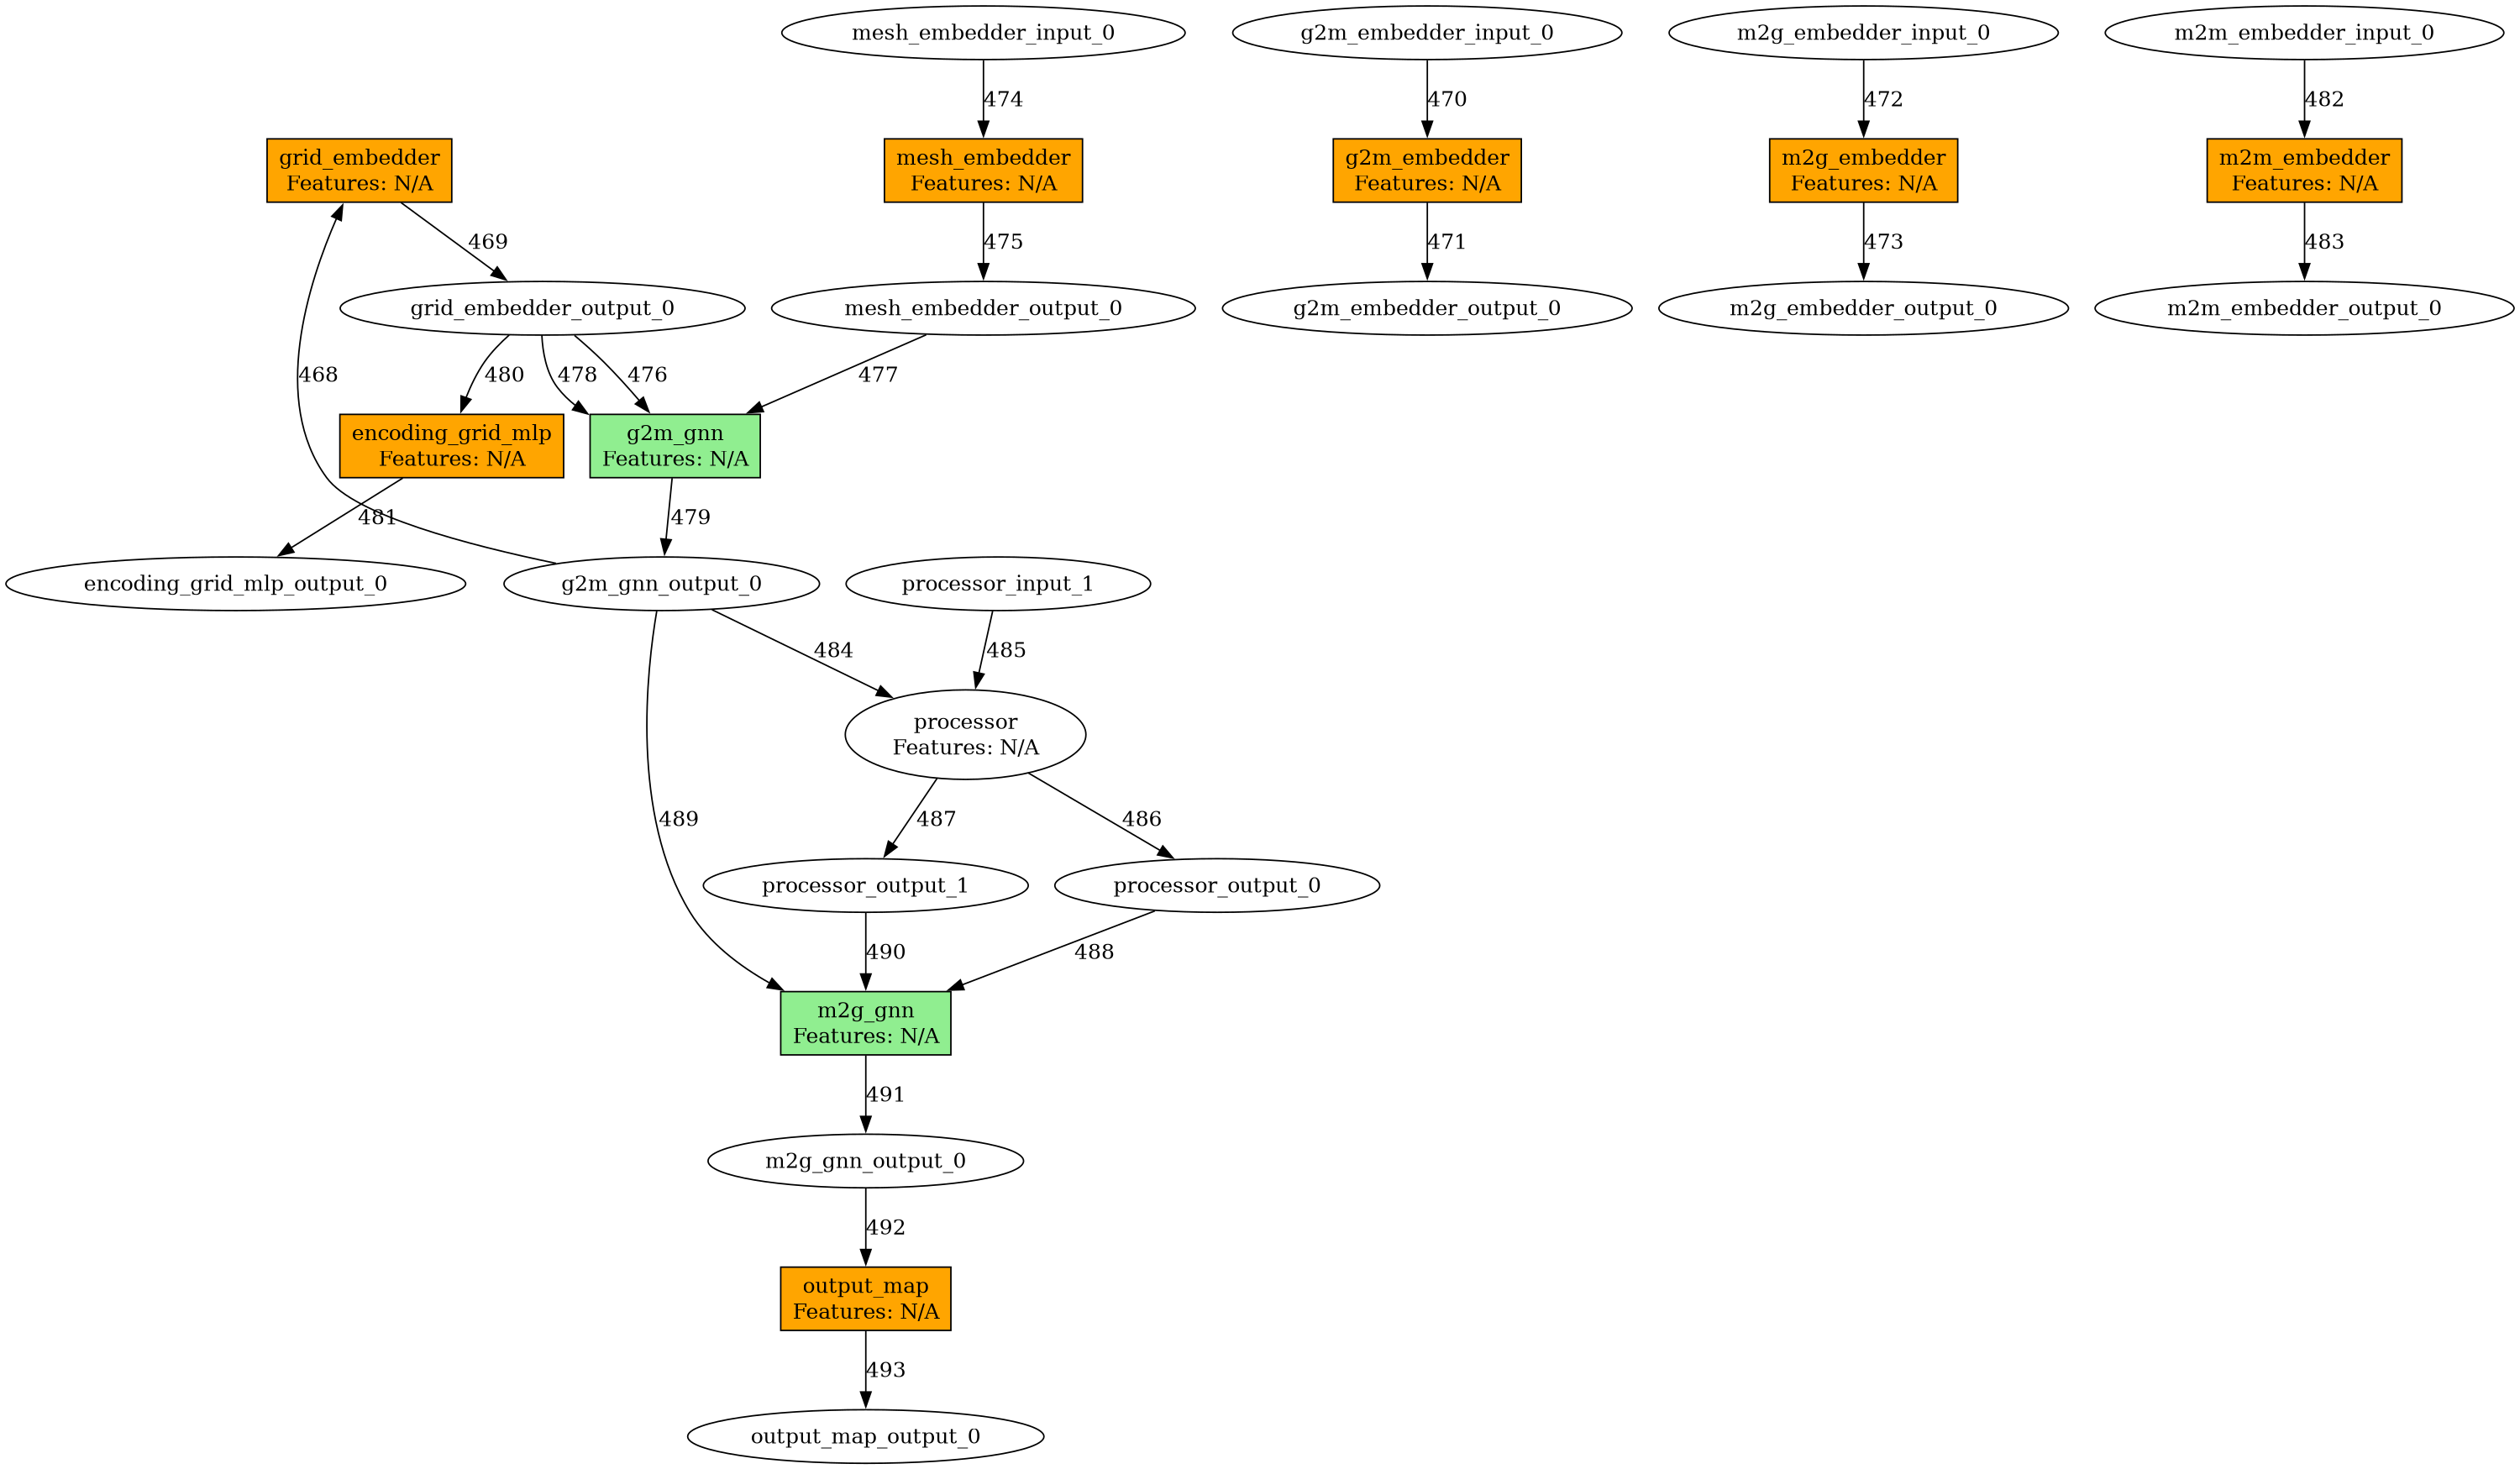

In [40]:
# Plot the simplified model I/O graph with numbered connections and tracking
graph = plot_simplified_model_io_graph_with_order_and_track(model, model_io)


Loaded graph with 70345 nodes (63784 grid, 6561 mesh)
Edges in subgraphs: m2m=51520, g2m=100656, m2g=255136


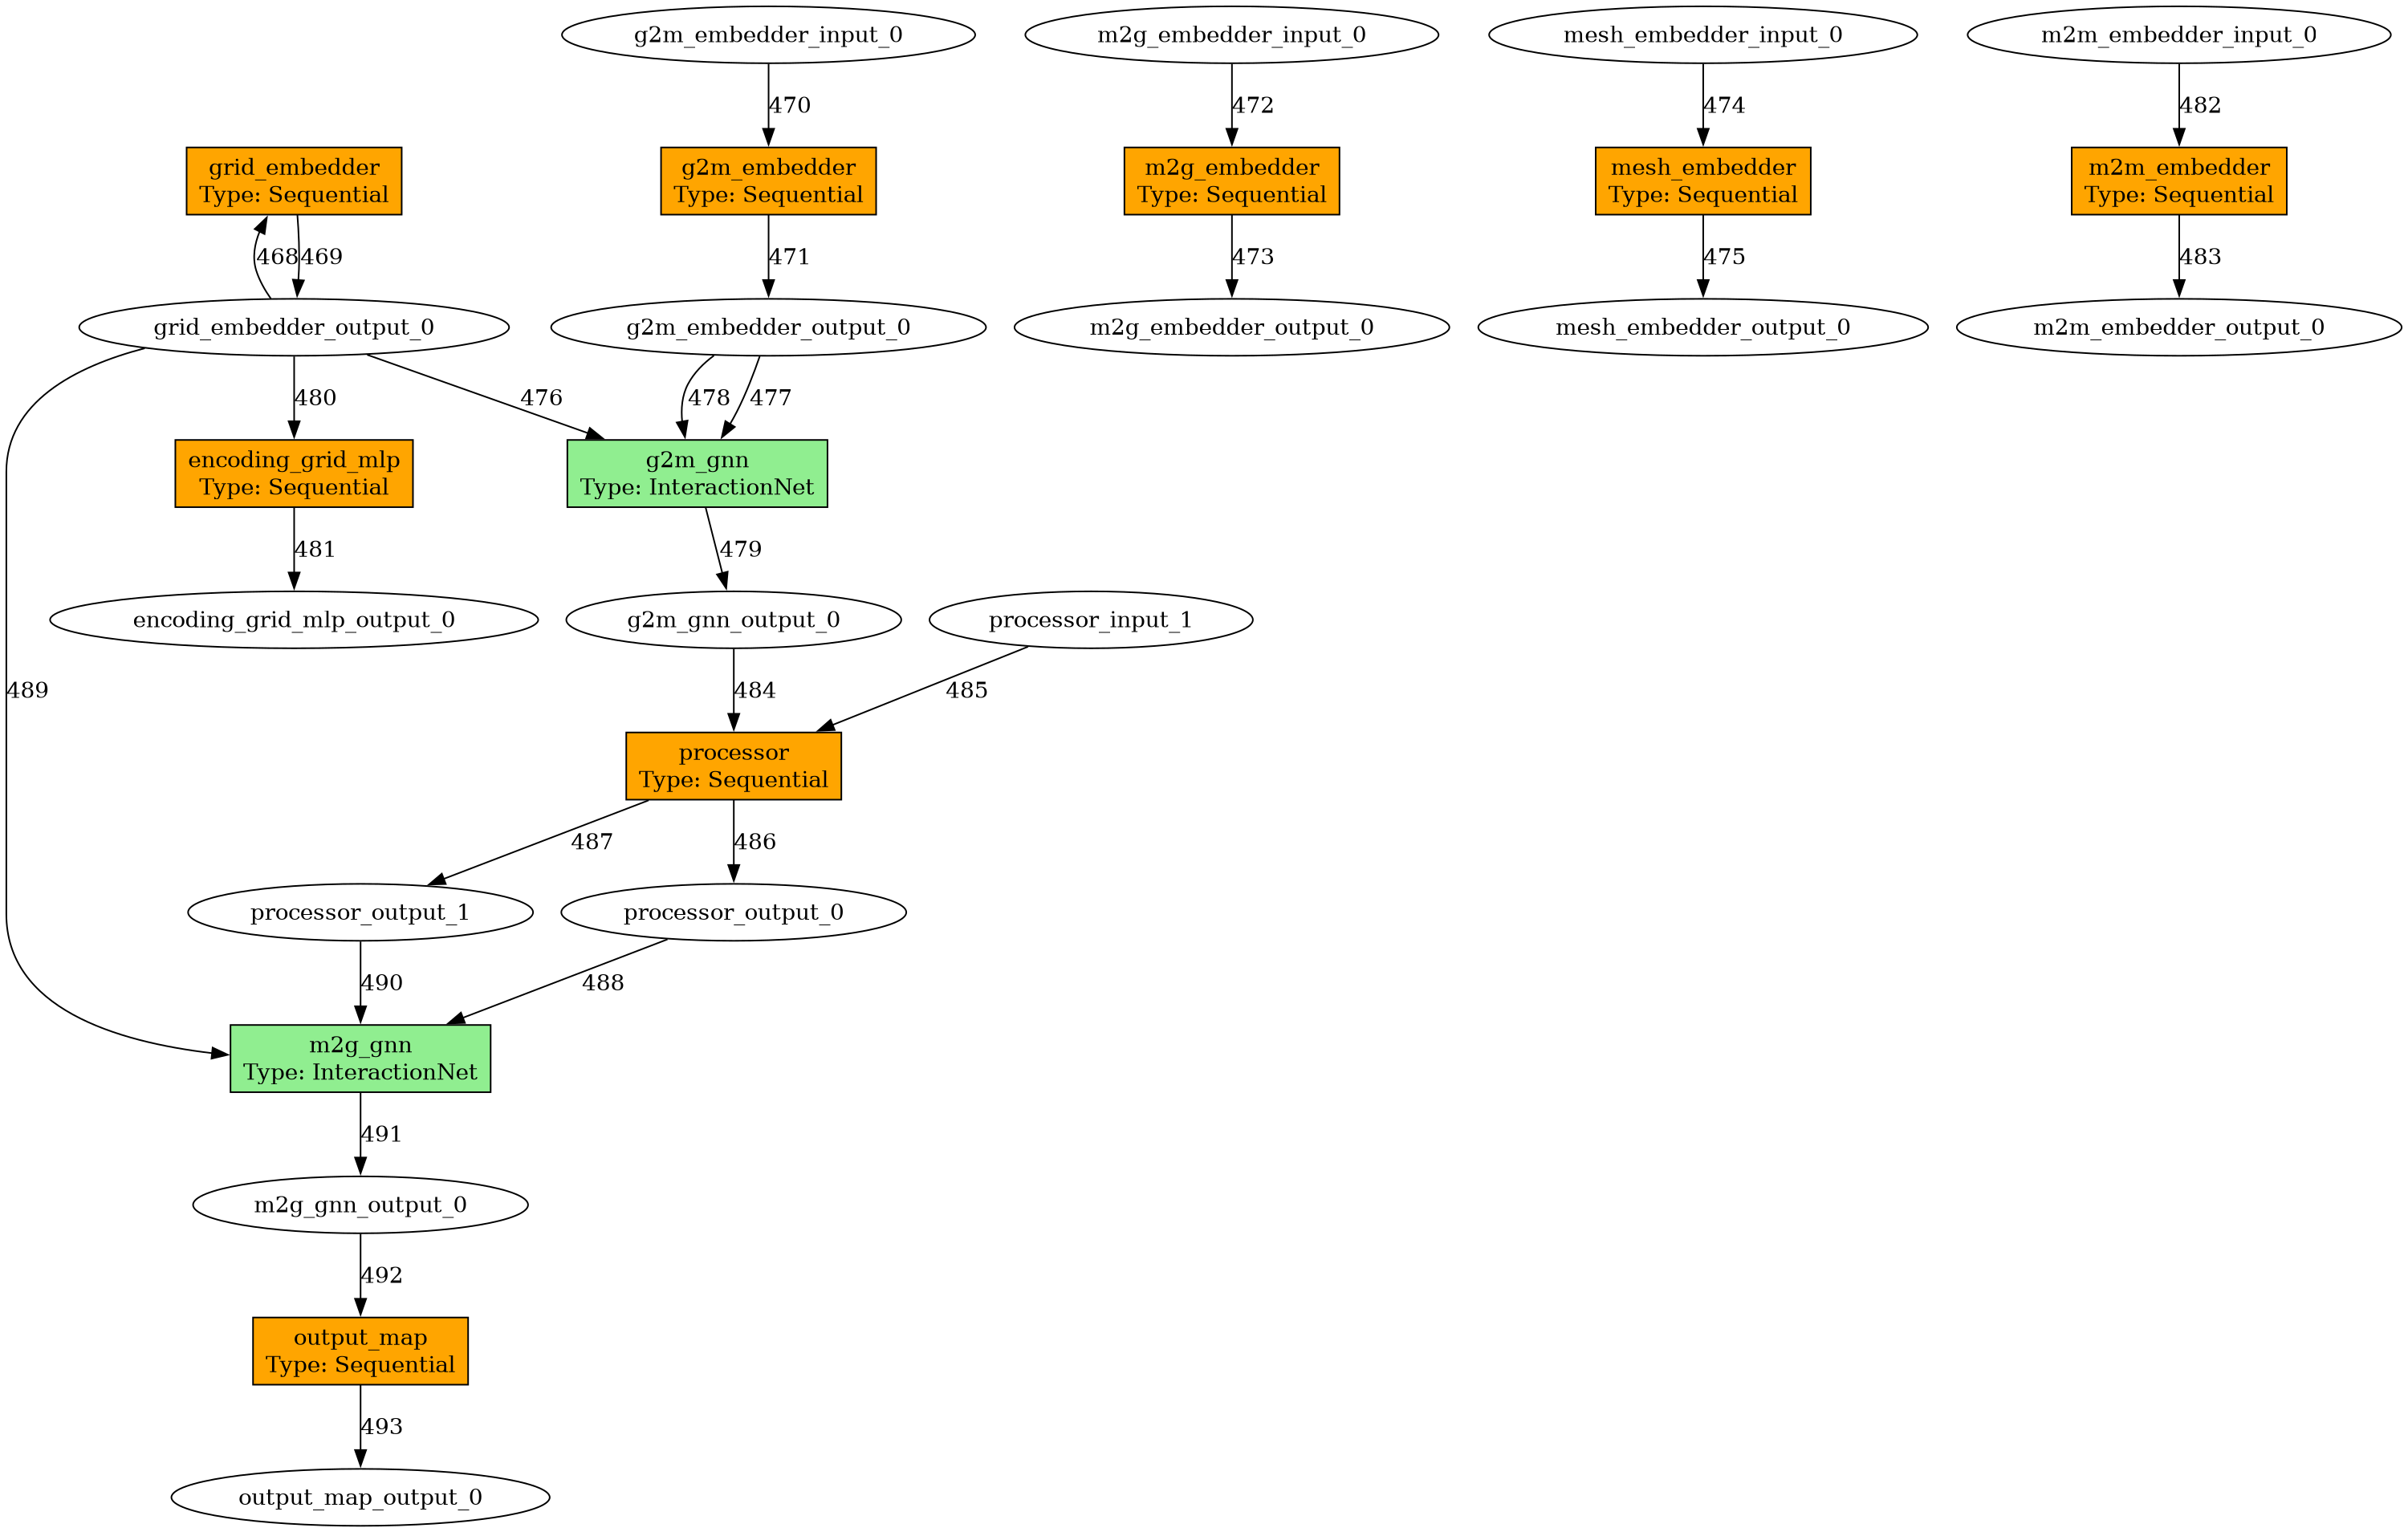

In [42]:
import torch
from graphviz import Digraph
from IPython.display import Image, display
from neural_lam.interaction_net import InteractionNet

def trace_lightning_model_io_with_order_and_track(model, dataloader):
    """
    Traces the PyTorch Lightning model to get the names of input and output tensors 
    along with the module hierarchy using a provided DataLoader, including the order
    of connections. It also tracks intermediate variables to ensure they are consistently
    represented in the diagram.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model to trace.
        dataloader (torch.utils.data.DataLoader): The DataLoader to supply inputs to the model.

    Returns:
        dict: A dictionary where keys are module names and values are tuples of (input_tensor_names, output_tensor_names, connection_order, module_type).
    """
    io_dict = {}
    tensor_id_to_name = {}
    order_counter = 0
    
    def register_hooks(module, module_name):
        def hook(module, inputs, outputs):
            nonlocal order_counter
            # Capture the top-level module name
            top_level_module_name = module_name.split('.')[0]
            # Record the inputs
            input_names = []
            input_order = []
            for i, inp in enumerate(inputs):
                if isinstance(inp, torch.Tensor):
                    tensor_id = id(inp)
                    if tensor_id not in tensor_id_to_name:
                        tensor_name = f"{top_level_module_name}_input_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                    else:
                        tensor_name = tensor_id_to_name[tensor_id]
                    input_names.append(tensor_name)
                    input_order.append(order_counter)
                    order_counter += 1

            # Record the outputs
            output_names = []
            output_order = []
            if isinstance(outputs, (tuple, list)):
                for i, out in enumerate(outputs):
                    if isinstance(out, torch.Tensor):
                        tensor_id = id(out)
                        tensor_name = f"{top_level_module_name}_output_{i}"
                        tensor_id_to_name[tensor_id] = tensor_name
                        output_names.append(tensor_name)
                        output_order.append(order_counter)
                        order_counter += 1
            else:
                if isinstance(outputs, torch.Tensor):
                    tensor_id = id(outputs)
                    tensor_name = f"{top_level_module_name}_output_0"
                    tensor_id_to_name[tensor_id] = tensor_name
                    output_names.append(tensor_name)
                    output_order.append(order_counter)
                    order_counter += 1

            # Store the mapping for this module
            module_type = type(module).__name__
            io_dict[top_level_module_name] = (input_names, output_names, input_order + output_order, module_type)
        
        module.register_forward_hook(hook)

    # Register hooks to top-level modules only
    for name, module in model.named_children():
        register_hooks(module, name)

    # Perform a forward pass using the dataloader to trigger the hooks
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            model.common_step(batch)  # Trigger forward pass
            break  # Only need one batch to trace

    return io_dict

def get_node_color(module_type):
    """
    Returns the color for the node based on the module type.
    """
    if module_type == 'Linear':
        return 'lightblue'
    elif module_type == 'InteractionNetWrapper' or module_type == 'InteractionNet':
        return 'lightgreen'
    elif module_type == 'Sequential':
        return 'orange'
    # Add other module types as needed
    return 'white'  # Default color

def plot_simplified_model_io_graph_with_order_and_track(model, io_dict, output_file='simplified_model_io_graph', format='png', dpi=300):
    """
    Plots a simplified version of the model's input/output tensor flow using graphviz,
    with numbered connections indicating the order of operations, and includes color-coding
    and annotations for the feature/channel count.

    Args:
        model (pl.LightningModule): The PyTorch Lightning model.
        io_dict (dict): A dictionary where keys are module names and values are tuples of 
                        (input_tensor_names, output_tensor_names, connection_order, module_type).
        output_file (str): The name of the output file (without extension).
        format (str): The format of the output file (e.g., 'png', 'svg', 'pdf').
        dpi (int): The resolution in dots per inch (DPI) for the output image.
    
    Returns:
        Digraph: The generated graph object.
    """
    dot = Digraph(comment='Simplified Model I/O Graph with Order')
    dot.attr(rankdir='TB', size='10')  # TB for top-bottom layout

    # Track unique tensors and simplify connections
    tensor_seen = set()

    for module_name, (input_names, output_names, order, module_type) in io_dict.items():
        # Get the module and determine its color and shape
        node_color = get_node_color(module_type)
        shape = 'box' if node_color != 'white' else 'ellipse'

        # Annotate the node with feature/channel count
        annotation = f"{module_name}\nType: {module_type}"
        
        # Create a node for the top-level module
        if module_name not in dot.node_attr:
            dot.node(module_name, annotation, shape=shape, style='filled', fillcolor=node_color)

        # Only show unique input tensors to avoid clutter
        for i, input_name in enumerate(input_names):
            if input_name not in tensor_seen:
                tensor_seen.add(input_name)
                dot.node(input_name, input_name, shape='ellipse')
            dot.edge(input_name, module_name, label=str(order[i]))

        # Only show unique output tensors to avoid clutter
        for i, output_name in enumerate(output_names):
            if output_name not in tensor_seen:
                tensor_seen.add(output_name)
                dot.node(output_name, output_name, shape='ellipse')
            dot.edge(module_name, output_name, label=str(order[len(input_names) + i]))

    # Set output resolution
    dot.attr(dpi=str(dpi))

    # Display the graph directly in the notebook
    display(Image(dot.pipe(format=format)))

    return dot

# Initialize your model with the given arguments
hidden_dim = 32
hidden_layers = 1
mesh_aggr = args.mesh_aggr
lr = args.lr
dataset = args.dataset
output_std = args.output_std
loss = args.loss
step_length = args.step_length
n_example_pred = args.n_example_pred
graph = args.graph
processor_layers = args.processor_layers

model = GraphLAM(hidden_dim, hidden_layers, mesh_aggr, lr, dataset, output_std, loss, step_length, n_example_pred, graph, processor_layers)

# Assuming eval_loader is your DataLoader
# eval_loader = torch.utils.data.DataLoader(...)  # Set up your DataLoader

# Trace the model I/O with order and tracking
model_io = trace_lightning_model_io_with_order_and_track(model, eval_loader)

# Plot the simplified model I/O graph with numbered connections, tracking, and feature/channel counts
graph = plot_simplified_model_io_graph_with_order_and_track(model, model_io)

In [43]:




for key, value in model_io.items():
  print('key', key)
  print('value', value)




key grid_embedder
value (['grid_embedder_output_0'], ['grid_embedder_output_0'], [468, 469], 'Sequential')
key g2m_embedder
value (['g2m_embedder_input_0'], ['g2m_embedder_output_0'], [470, 471], 'Sequential')
key m2g_embedder
value (['m2g_embedder_input_0'], ['m2g_embedder_output_0'], [472, 473], 'Sequential')
key mesh_embedder
value (['mesh_embedder_input_0'], ['mesh_embedder_output_0'], [474, 475], 'Sequential')
key g2m_gnn
value (['grid_embedder_output_0', 'g2m_embedder_output_0', 'g2m_embedder_output_0'], ['g2m_gnn_output_0'], [476, 477, 478, 479], 'InteractionNet')
key encoding_grid_mlp
value (['grid_embedder_output_0'], ['encoding_grid_mlp_output_0'], [480, 481], 'Sequential')
key m2m_embedder
value (['m2m_embedder_input_0'], ['m2m_embedder_output_0'], [482, 483], 'Sequential')
key processor
value (['g2m_gnn_output_0', 'processor_input_1'], ['processor_output_0', 'processor_output_1'], [484, 485, 486, 487], 'Sequential')
key m2g_gnn
value (['processor_output_0', 'grid_embedder_o